# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as progress

In [2]:
data_dir = "./data"
random_state = 777

%pylab inline
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.figure_format = 'retina'

# отключаем ворнинги
import warnings
warnings.simplefilter('ignore')

# дефолтный размер графиков
from pylab import rcParams
# rcParams['figure.figsize'] = 14,9

Populating the interactive namespace from numpy and matplotlib


In [63]:
# Проверяем, есть ли дубликаты новостей на один и тот же день
news_dates = pd.read_csv(os.path.join(data_dir, 'texts.csv')).date.value_counts()
print({
    True: "На одну дату может быть несколько новостей",
    False: "На одну дату только одна новость"
}[len(news_dates[news_dates > 1]) > 0])

На одну дату только одна новость


In [48]:
def read_data():
    news = pd.read_csv(os.path.join(data_dir, 'texts.csv'))
    prices = pd.read_csv(os.path.join(data_dir, 'gazprom_prices.csv'), sep=';', )
    news.date = pd.to_datetime(news.date, format='%d.%m.%Y')
    prices['date'] = pd.to_datetime(prices.Date, format='%d.%m.%Y')
    prices.drop(['Date'], axis=1, inplace=True)
    for column in ('Open','ClosingPrice', 'DailyHigh', 'DailyLow'):
        prices[column] = prices[column].map(
            lambda price: np.float32(price.replace(',', '.')),
            na_action='ignore'
        )
    # Назначаем date индексом, проверено: дубликатов новостей на одну дату нет
    return news.set_index('date'), prices.set_index('date')

In [64]:
news, prices = read_data()
news.head()

,text
date,
2017-11-09,Компания рассчитывает на решение по газовому с...
2017-11-08,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2017-11-01,Новая редакция американских санкций ставит по...
2017-10-30,"Как стало известно “Ъ”, известный на рынке ри..."
2017-10-23,"НОВАТЭК, который через пять лет собирается за..."


In [65]:
prices.head(5)

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
date,,,,,
2017-12-08,133.429993,132.600006,133.899994,132.000000,16037970
2017-12-07,133.699997,133.020004,133.869995,132.809998,18198430
2017-12-06,133.330002,134.000000,134.289993,132.910004,14641730
2017-12-05,133.479996,133.649994,133.990005,132.779999,12684800
2017-12-04,133.009995,133.770004,134.000000,131.929993,17818980


## Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

### Корелляция между средней длинной текста за день и ценой закрытия
#### Вычисляем длины новостей

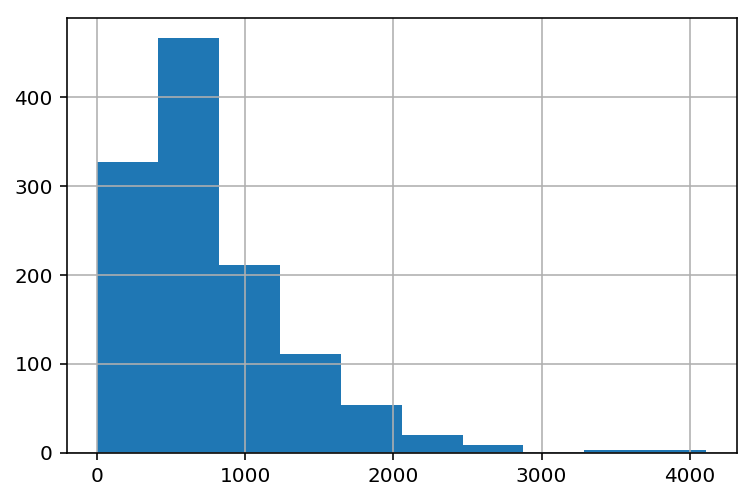

In [66]:
news['len'] = news.text.apply(len)
news.len.hist();

#### Проверяем, совпадают ли диапозоны дат новостей и котировок

In [67]:
news_date_from, news_date_to = news.index.min(), news.index.max()
prices_date_from, prices_date_to = prices.index.min(), prices.index.max()
date_from = max(news_date_from, prices_date_from)
date_to = min(news_date_to, prices_date_to)
print("Даты новостей: {:%Y.%m.%d} - {:%Y.%m.%d}".format(news_date_from, news_date_to))
print("Даты цен: {:%Y.%m.%d} - {:%Y.%m.%d}".format(prices_date_from, prices_date_to))
print("Даты с новостями и ценами: {:%Y.%m.%d} - {:%Y.%m.%d}".format(date_from, date_to))

Даты новостей: 2010.01.04 - 2017.11.09
Даты цен: 2010.01.11 - 2017.12.08
Даты с новостями и ценами: 2010.01.11 - 2017.11.09


#### Формируем выборку по датам на которые есть цена и новость

In [68]:
def filter_common_dates(prices, news, date_from, date_to):
    return (
        prices.loc[(prices.index >= date_from) & (prices.index <= date_to)],
        news.loc[(news.index >= date_from) & (news.index <= date_to)]
    )

common_prices, common_news = filter_common_dates(prices, news, date_from, date_to)
closing_prices = common_prices[['ClosingPrice']]
prices_vs_news_len = closing_prices.join(common_news.len).fillna(0)
prices_vs_news_len.head()

,ClosingPrice,len
date,,
2017-11-09,131.500000,419.0
2017-11-08,132.300003,624.0
2017-11-07,132.279999,0.0
2017-11-03,125.900002,0.0
2017-11-02,125.669998,0.0


####  Корреляция цены закрытия с длиной текста и против случайного массива

In [69]:
from scipy.stats import pearsonr

# Корреляция сдлиной текста новости
pearsonr(prices_vs_news_len.ClosingPrice, prices_vs_news_len.len)

(-0.05536274198156127, 0.014060710868536922)

In [70]:
# Корреляция со случайным вектором такой же длины
random_vals = np.random.rand(len(prices_vs_news_len.ClosingPrice))
pearsonr(prices_vs_news_len.ClosingPrice, random_vals)

(-0.046566073507463883, 0.03891794326819277)

**Вывод:** корреляция отсутствует

### Очистка текста и лематизация

In [530]:
%%time 
from pymystem3 import Mystem

def lemmatize(text, lemmatizer):
    text = text.replace('\xa0', ' ')
    try:
        return "".join(lemmatizer.lemmatize(text)).strip()  
    except:
        return " "

news['text_norm'] = news.text.apply(lemmatize, lemmatizer=Mystem())

CPU times: user 475 ms, sys: 50.8 ms, total: 526 ms
Wall time: 6.82 s


### Корреляция между числом упоминанием Миллера и ценой закрытия
#### Считаем число упоминаний

In [531]:
news['miller_count'] = news.text_norm.map(
    lambda text: text.count('миллер') if text else 0,
    na_action='ignore'
)

In [532]:
print(news.sort_values(by=['miller_count'], ascending=False).head(1).text[0].replace(
    'Миллер', '◀Миллер▶'
))

 "Газпром" принял решение о целесообразности строительства еще двух ниток "Северного потока"; одна из новых веток может дойти до Великобритании, состав участников проекта ее строительства может отличаться от нынешнего состава акционеров Nord Stream AG, сообщил председатель правления "Газпрома" Алексей ◀Миллер▶ на пресс-конференции в пятницу.
 "Газпром" принял решение о целесообразности строительства еще двух ниток "Северного потока"; одна из новых веток может дойти до Великобритании, состав участников проекта ее строительства может отличаться от нынешнего состава акционеров Nord Stream AG, сообщил председатель правления "Газпрома" Алексей ◀Миллер▶ на пресс-конференции в пятницу.
 "Газпром" в 2013 г. может рассмотреть возможность выплаты дивидендов в 25% чистой прибыли по МСФО, сообщил председатель правления российского газового холдинга Алексей ◀Миллер▶ на пресс-конференции в пятницу. Минфин России полагает, что госкомпании должны платить в качестве дивидендов не менее 25% чистой прибы

#### Считаем корреляцию

In [533]:
common_prices, common_news = filter_common_dates(prices, news, date_from, date_to)
prices_vs_miller_counts = closing_prices.join(common_news.miller_count).fillna(0)
prices_vs_miller_counts[prices_vs_miller_counts.miller_count > 2].head()

,ClosingPrice,miller_count
date,,
2016-06-30,139.509995,3.0
2015-06-26,145.179993,4.0
2014-10-07,137.100006,3.0
2014-06-16,145.199997,3.0
2013-09-06,141.970001,3.0


In [534]:
prices_vs_miller_counts.miller_count.value_counts()

0.0    1868
1.0      69
2.0      19
3.0       7
4.0       2
5.0       1
6.0       1
Name: miller_count, dtype: int64

In [535]:
# Корреляция цены акций на момент закрытия с числом упоминания Миллера в новостях
pearsonr(prices_vs_miller_counts.ClosingPrice, prices_vs_miller_counts.miller_count)

(-0.007440481290018384, 0.74156117961881796)

In [536]:
np.corrcoef(
    prices_vs_miller_counts.ClosingPrice.tolist(), 
    prices_vs_miller_counts.miller_count.tolist()
)

array([[ 1.        , -0.00744048],
       [-0.00744048,  1.        ]])

**Вывод:** корреляция отсутствует

### Упоминания в новостях северного и турецкого потока (газопроводы)

In [537]:
print("Северный поток: {}\nТурецкий поток: {}".format(
    sum(news.text_norm.map(lambda text: text.count('северный поток'))),
    sum(news.text_norm.map(lambda text: text.count('турецкий поток')))
))

Северный поток: 15
Турецкий поток: 39


**Вывод:** упоминаний «турецкого потока» в 2.5 раза больше, чем «северного»

### О каких санкциях пишут в статьях?
#### Парсим новости с помощью SyntaxNet

In [538]:
def save_texts(texts, file_name):
    with open(file_name, 'w') as f:
        for text in texts:
            f.write("{}\n".format(
                text.replace('\n', ' ').replace('\r', '').replace('\t', ' ')
            ))

save_texts(news.text, 'news_texts.txt')

In [30]:
! cat ./news_texts.txt | docker run --rm -i inemo/syntaxnet_rus > news_texts.conll

2017-12-17 15:08:29.835639: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-17 15:08:29.835639: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-17 15:08:29.835639: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-17 15:08:29.835772: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-

2017-12-17 15:08:30.120884: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-17 15:08:30.138862: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-17 15:08:30.149877: I syntaxnet/term_frequency_map.cc:101] Loaded 31 terms from ./syntaxnet/models/Russian-SynTagRus/tag-map.
2017-12-17 15:08:31.290279: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building training network with parameters: feature_sizes: [12 20 20 20] domain_sizes: [    37     66     33 103475]
2017-12-17 15:08:31.529283: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2017-12-17 15:08:31.536480: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building trai

2017-12-17 15:08:33.374214: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-17 15:08:33.380874: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-17 15:08:33.961484: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2017-12-17 15:08:34.744235: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2017-12-17 15:08:34.756067: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 178 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Total processed documents: 1202
INFO:tensorflow:num correct tokens: 0
INFO:tensorflow:total tokens: 122137
INFO:tensorflow:Seconds elapsed in evaluation: 121

In [539]:
from nltk import DependencyGraph

def read_connlu(file_name):
    """
    Читает и парсит файл ф вормате CoNLL-U
    с данными результатов синтаксического анализа SyntaxNet
    """
    sentences = []
    sentence = []    
    with open(file_name, 'r') as file:
        for line in file.readlines():
            line = line.strip()

            # Пустая строка — конец предложения
            if not line:
                sentences.append(sentence)
                sentence = []                
                    
            # Не комментарий                    
            elif not line.startswith('#'):  
                items = line.split("\t")
                assert len(items) == 10
                sentence.append("\t".join(items) + '\n')  
                
    return sentences


def iter_depency_graphs(sentences):
    for n, sentence in enumerate(sentences):
        yield n, DependencyGraph(tree_str=sentence, cell_separator='\t')

In [540]:
sentences = read_connlu('news_texts.conll')

print(news.text[0], '\n')

for n, graph in iter_depency_graphs(sentences[:1]):
    print("{}\n=============".format(n))
    for triple in graph.triples():
        if triple:
            print(triple)

Компания рассчитывает на решение по газовому спору с Украиной до конца декабря «Газпром» ожидает решения Стокгольмского арбитража по транзитному спору с украинским «Нафтогазом» не позднее февраля 2018 года, хотя раньше компания прогнозировала, что это произойдет до 30 ноября. Решение по взаимным искам об условиях поставок газа на Украину, по мнению монополии, суд может принять на месяц раньше — до декабря 2017 года. 

0
(('рассчитывает', 'VERB'), 'nsubj', ('Компания', 'NOUN'))
(('рассчитывает', 'VERB'), 'dobj', ('решение', 'NOUN'))
(('решение', 'NOUN'), 'case', ('на', 'ADP'))
(('решение', 'NOUN'), 'dobj', ('спору', 'NOUN'))
(('спору', 'NOUN'), 'case', ('по', 'ADP'))
(('спору', 'NOUN'), 'amod', ('газовому', 'ADJ'))
(('спору', 'NOUN'), 'dobj', ('Украиной', 'NOUN'))
(('Украиной', 'NOUN'), 'case', ('с', 'ADP'))
(('рассчитывает', 'VERB'), 'parataxis', ('ожидает', 'VERB'))
(('ожидает', 'VERB'), 'nmod', ('конца', 'NOUN'))
(('конца', 'NOUN'), 'case', ('до', 'ADP'))
(('конца', 'NOUN'), 'nmod', 

#### Выделяем данные по санкциям

In [541]:
from collections import Counter

s_amod = Counter()
s_nmod_dobj = Counter()
o_nmod_dobj = Counter()
o_verb = Counter()

def normalize_phrase(*words):
    phrase = ' '.join(filter(None, words))
    return {
        'западных санкций': 'западные санкции',
        'секторальных санкций': 'секторальные санкции',
        'штрафных санкций': 'штрафные санкции',
        'американских санкций': 'американские санкции',
        'антироссийскими санкциями': 'антироссийские санкции',
        'экономическими санкциями': 'экономические санкции',
        'очередных санкций': 'очередные санкции',
        'санкций США': 'санкции США'
    }.get(phrase, phrase)


def iter_graph_tripples(graph):
    for (obj_word, obj_tag), pred, (subj_word, subj_tag) in graph.triples():
        obj_word = obj_word.strip(':,."«»-–—')
        subj_word = subj_word.strip(':,."«»-–—')
        yield (obj_word, obj_tag), pred, (subj_word, subj_tag)

        
def find_by_pred(
    graph, preds=None,
    obj_word=None, obj_tag=None, 
    subj_word=None, subj_tag=None
):
    """
    Ищет в синтаксическом графе тройку (target, target_pred, X)
    И возвращает слово X
    """
    find_subj = subj_word is None
    if preds is not None and not isinstance(preds, set):
        preds = {preds}
        
    for obj, pred, subj in iter_graph_tripples(graph):
        _obj_word, _obj_tag = obj
        _subj_word, _subj_tag = subj
        
        if (
            (preds is None or pred in preds) and
            (obj_word is None or obj_word == _obj_word) and
            (obj_tag is None or obj_tag == _obj_tag) and
            (subj_word is None or subj_word == _subj_word) and                
            (subj_tag is None or subj_tag == _subj_tag)               
        ):
            return _subj_word if find_subj else _obj_word

for n, graph in iter_depency_graphs(sentences):
    for (obj_word, obj_tag), pred, (subj_word, subj_tag) in iter_graph_tripples(graph):
        if obj_word.startswith('санкц'):
            if pred == 'amod' and subj_tag == 'ADJ':
                s_amod.update([normalize_phrase(subj_word, obj_word)])             
            elif pred in ('nmod', 'dobj') and subj_tag == 'NOUN':
                case = find_by_pred(graph, 'case', obj_word=subj_word)
                s_nmod_dobj.update([normalize_phrase(obj_word, case, subj_word)])   
                
        elif subj_word.startswith('санкц'): 
            if pred in ('nmod', 'dobj')  and obj_tag == 'NOUN':
                case_obj = find_by_pred(graph, 'case', obj_word=obj_word)
                case_subj = find_by_pred(graph, 'case', obj_word=subj_word)
                o_nmod_dobj.update([
                    normalize_phrase(case_obj, obj_word, case_subj, subj_word)
                ])   
            elif obj_tag == 'VERB':
                case = find_by_pred(graph, 'case', obj_word=subj_word)
                o_verb.update([normalize_phrase(obj_word, case, subj_word)])              
        
                
def print_counted_list(counter, title, count=30):
    print('\n' + title)
    print('===============')
    print(', '.join(
        '{} ({})'.format(item, count) if count > 1 else item
        for item, count in counter.most_common(count)
    ))
    
print_counted_list(s_amod, 'санкц... amod ADJ (какие санкциии)')
print_counted_list(s_nmod_dobj, 'санкц... nmod|dobj NOUN (санкции of ...)')   
print_counted_list(o_nmod_dobj, 'NOUN nmod|dobj санкц... (... of санкций)')
print_counted_list(o_verb, 'VERB санкц...')


санкц... amod ADJ (какие санкциии)
западные санкции (7), штрафные санкции (3), секторальные санкции (2), международные санкции (2), американские санкции, очередные санкции, экономические санкции, антироссийские санкции, персональные санкции, визовые санкции

санкц... nmod|dobj NOUN (санкции of ...)
санкции США (5), санкциями на территории (2), санкций против РФ (2), санкций против банка, санкций Перевод, санкциями против России, санкции за публикации, санкции о заказчике, санкциями стран, санкций для Газпрома, санкций ExxonMobil, санкций Газпром, санкции против Газпрома, санкции к компаниям, санкции за неготовность, санкций для монополии

NOUN nmod|dobj санкц... (... of санкций)
введения санкций (4), влияния санкций (4), в условиях санкций (3), редакция санкций, с ННК из-за санкций, правомерность санкций, на фоне санкций, риску санкций, последствия санкций, от проектов санкциями, волну санкций, развития санкции, эффект из-за санкций, вступления санкций, под виток санкций, ситуации под

**Вывод:** международные-американские-западные экономические санкции в отношении РФ и визовые санкции для отдельных персоналий

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [542]:
# Добавляем бинарный признак уменьшения стоимости акции за день
prices['ClosingPrice_bin'] = prices.apply(lambda row: 1 if row.ClosingPrice >= row.Open else 0, axis=1)
prices.head()

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
date,,,,,,
2017-12-08,133.429993,132.600006,133.899994,132.000000,16037970,0
2017-12-07,133.699997,133.020004,133.869995,132.809998,18198430,0
2017-12-06,133.330002,134.000000,134.289993,132.910004,14641730,1
2017-12-05,133.479996,133.649994,133.990005,132.779999,12684800,1
2017-12-04,133.009995,133.770004,134.000000,131.929993,17818980,1


In [825]:
# Оставляем даты на которые известны и цены и новости
common_prices, common_news = filter_common_dates(prices, news, date_from, date_to)
print("Новостей в общем диапозоне дат", common_news.shape[0])
print("Данных по ценам в общем диапозоне дат", common_prices.shape[0])

common_news = common_news.loc[common_prices.index].dropna()
closing_prices_bin = common_prices.loc[common_news.index].ClosingPrice_bin
print("Данных с ценами и новостями", closing_prices_bin.shape[0])

X = common_news.text_norm
y = closing_prices_bin

Новостей в общем диапозоне дат 1202
Данных по ценам в общем диапозоне дат 1967
Данных с ценами и новостями 1159


In [826]:
# Делим на обучающую и тестовую выборки
def split_data_by_year(X, y, year=2016):
    train_idx = X.index.year < year
    test_idx = X.index.year >= year
    X_train = X.loc[train_idx]
    X_test = X.loc[test_idx]
    y_train = y.loc[train_idx]    
    y_test = y.loc[test_idx]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data_by_year(X, y)
X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]

(901, 901, 258, 258)

In [827]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [828]:
rus_regex = re.compile(r"[а-яё][а-яё\-–]+", re.UNICODE | re.MULTILINE | re.IGNORECASE)
stop_words = stopwords.words('russian')

In [908]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def predict_and_score(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print("Accuracy:    {0:.2f}".format(accuracy_score(y_test, y_predict)))  
    print("F1-measure:  {0:.2f}".format(f1_score(y_test, y_predict)))  #, average='macro'
    print("Precision:   {0:.2f}".format(precision_score(y_test, y_predict)))
    print("Recall:      {0:.2f}".format(recall_score(y_test, y_predict)))    
    return y_predict

In [915]:
def tune_model(pipeline, parameters, X, y, n_iter=50, cv=2, scoring='accuracy'):
    grid_search = RandomizedSearchCV(
        pipeline, parameters, 
        cv=cv, scoring=scoring, n_iter=n_iter, 
        random_state=random_state, n_jobs=1
    )
    grid_search.fit(X, y)

    print("Лучший результат: %0.3f" % grid_search.best_score_)
    print("Лучшие параметры:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("\nНа тестовых данных:" % grid_search.best_score_)
    predict_and_score(grid_search.best_estimator_, *split_data_by_year(X, y));

###  SGDClassifier

In [916]:
tune_model(
    Pipeline([
        ('vect', CountVectorizer(stop_words=stop_words)),
        ('tfidf', TfidfTransformer()),
        ('reducer', TruncatedSVD(random_state=random_state)),
        ('normalizer', StandardScaler()),
        ('clf', SGDClassifier(random_state=random_state))
    ]),
    {
        'vect__token_pattern': [rus_regex],
        'vect__stop_words': [stop_words, None], 
        'vect__ngram_range': [(1, 1), (1, 2)],
        'vect__max_df': [0.6, 0.7, 0.75, 0.8],
        'vect__min_df': [1, 2, 3, 4],
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__use_idf': [True, False], 
        'tfidf__smooth_idf': [True, False],     
        'tfidf__sublinear_tf': [True, False],       
        'reducer__n_components': [10, 20, 30, 40, 50],
        'reducer__n_iter': [10, 20, 30, 40, 50],  
        'clf__penalty': ['elasticnet', 'l2'],
        'clf__max_iter': [5, 10, 20, 40],    
        'clf__alpha': [0.00001, 0.000001, 0.0000001],  
    },
    X, y
)

Лучший результат: 0.514
Лучшие параметры:
	clf__alpha: 1e-06
	clf__max_iter: 20
	clf__penalty: 'l2'
	reducer__n_components: 20
	reducer__n_iter: 10
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__sublinear_tf: True
	tfidf__use_idf: False
	vect__max_df: 0.6
	vect__min_df: 1
	vect__ngram_range: (1, 1)
	vect__stop_words: None
	vect__token_pattern: re.compile('[а-яё][а-яё\\-–]+', re.IGNORECASE|re.MULTILINE)

На тестовых данных:
Accuracy:    0.52
F1-measure:  0.31
Precision:   0.46
Recall:      0.23


In [987]:
# Пытаемся ещё улучшть врчную
predict_and_score(
    Pipeline([
        ('vect', CountVectorizer(
            ngram_range=(1, 2), 
            max_df=0.75, 
            min_df=2, 
            token_pattern=rus_regex,
        )),
        ('tfidf', TfidfTransformer(smooth_idf=True, sublinear_tf=False, use_idf=False)),
        ('reducer', TruncatedSVD(n_components=40, n_iter=50, random_state=random_state)),
        ('normalizer', StandardScaler()),
        ('clf', SGDClassifier(random_state=random_state, penalty='elasticnet', max_iter=20, alpha=1e-07))
    ]),
    X_train, X_test, y_train, y_test
);

Accuracy:    0.57
F1-measure:  0.54
Precision:   0.53
Recall:      0.55


In [989]:
print("\nБез TF-IDF")
predict_and_score(
    Pipeline([
        ('vect', CountVectorizer(
            ngram_range=(1, 2), 
            max_df=0.75, 
            min_df=2, 
            token_pattern=rus_regex,
        )),
        ('reducer', TruncatedSVD(n_components=40, n_iter=50, random_state=random_state)),
        ('normalizer', StandardScaler()),
        ('clf', SGDClassifier(random_state=random_state, penalty='elasticnet', max_iter=20, alpha=1e-07))
    ]),
    X_train, X_test, y_train, y_test
);

print("\nБез TF-IDF и SVD")
predict_and_score(
    Pipeline([
        ('vect', CountVectorizer(
            ngram_range=(1, 2), 
            max_df=0.75, 
            min_df=2, 
            token_pattern=rus_regex,
        )),
        ('clf', SGDClassifier(random_state=random_state, penalty='elasticnet', max_iter=20, alpha=1e-07))
    ]),
    X_train, X_test, y_train, y_test
);


Без TF-IDF
Accuracy:    0.51
F1-measure:  0.43
Precision:   0.46
Recall:      0.40

Без TF-IDF и SVD
Accuracy:    0.53
F1-measure:  0.50
Precision:   0.48
Recall:      0.52


## RandomForestClassifier

In [967]:
predict_and_score(
    Pipeline([
        ('vect', CountVectorizer(
            ngram_range=(1, 2), 
            max_df=0.75, 
            min_df=3, 
            stop_words=stop_words, 
            token_pattern=rus_regex,
        )),
        ('tfidf', TfidfTransformer()),
        ('reducer', TruncatedSVD(n_components=40, n_iter=50, random_state=random_state)),
        ('clf', RandomForestClassifier(
            n_estimators=130, 
            min_samples_leaf=2,
            min_samples_split=2,
            max_depth=5,
            random_state=random_state
        )),
    ]),
    X_train, X_test, y_train, y_test
);

Accuracy:    0.56
F1-measure:  0.40
Precision:   0.54
Recall:      0.32


In [970]:
print("\nБез TF-IDF")
predict_and_score(
    Pipeline([
        ('vect', CountVectorizer(
            ngram_range=(1, 2), 
            max_df=0.75, 
            min_df=3, 
            stop_words=stop_words, 
            token_pattern=rus_regex,
        )),
        ('reducer', TruncatedSVD(n_components=40, n_iter=50, random_state=random_state)),
        ('clf', RandomForestClassifier(
            n_estimators=130, 
            min_samples_leaf=2,
            min_samples_split=2,
            max_depth=5,
            random_state=random_state
        )),
    ]),
    X_train, X_test, y_train, y_test
);


Без TF-IDF
Accuracy:    0.50
F1-measure:  0.32
Precision:   0.42
Recall:      0.25


### Выводы
- Лучше всего сработал **`SGDClassifier`**. Так же тестировались **`MultinomialNB`** и **`LogisticRegression`**, результаты были ещё хуже **`RandomForestClassifier`**
- В общем-то эффективность получившегося предсказателя близка к рандому :(
- **`Tf-IDf`** + **`SVD`** немного, но улучшает качество

###### Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     